# Installs & Imports

In [ ]:
!pip install -q torch_geometric

In [ ]:
import torch
TORCH = torch.__version__.split("+")[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '') if torch.cuda.is_available() else 'cpu'
print(f"PyTorch version: {TORCH}")
print(f"CUDA version: {CUDA}")

PyTorch version: 2.2.1
CUDA version: cu121


In [ ]:
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html

In [ ]:
import torch_geometric
torch_geometric.__version__

'2.5.1'

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import os
import sys
import shutil
import time
import logging
import random
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, ndcg_score,
    average_precision_score, cohen_kappa_score, roc_auc_score, auc, roc_curve,
    precision_recall_curve
)

from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from tensorboard.backend.event_processing import event_accumulator

from torch_geometric.data import HeteroData, Data, Batch
import torch_geometric.transforms as T
from torch_geometric.nn import SAGEConv, GATConv, HeteroConv, to_hetero
from torch_geometric.loader import LinkNeighborLoader

import networkx as nx

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

Mounted at /content/drive


# Loading the Data

In [ ]:
# Path to the files
movies_path = '/content/drive/MyDrive/Datasets/ml-latest-small/movies.csv'
ratings_path = '/content/drive/MyDrive/Datasets/ml-latest-small/ratings.csv'

In [ ]:
# Load the files as DataFrames
movies_df = pd.read_csv(movies_path)
ratings_df = pd.read_csv(ratings_path)

In [ ]:
# Movies DataFrame
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Ratings DataFrame
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Cleaning the Data

In [ ]:
# Merge the movies with ratings
full_df = pd.merge(movies_df, ratings_df, on='movieId', how='left')
full_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


In [ ]:
# Check for NaN values in the columns
print(f"Missing values:\n{full_df.isnull().sum()}")

Missing values:
movieId       0
title         0
genres        0
userId       18
rating       18
timestamp    18
dtype: int64


In [ ]:
# Remove rows with NaN timestamps
full_df = full_df.dropna()
print(f"Missing values:\n{full_df.isnull().sum()}")

Missing values:
movieId      0
title        0
genres       0
userId       0
rating       0
timestamp    0
dtype: int64


In [ ]:
# Convert timestamps to datetime objects
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'], unit='s')
full_df.head()

<ipython-input-13-f80e4cc589cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df['timestamp'] = pd.to_datetime(full_df['timestamp'], unit='s')


,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08 06:36:02
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25 06:52:26
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13 12:59:30
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18 05:28:03


In [ ]:
# Create a new column for release year
full_df['release_year'] = full_df['title'].str.extract(r'\((\d{4})\)')
full_df.head()

,movieId,title,genres,userId,rating,timestamp,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,1995
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08 06:36:02,1995
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25 06:52:26,1995
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13 12:59:30,1995
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18 05:28:03,1995


In [ ]:
# Remove the year from title
full_df['title'] = full_df['title'].str.replace(r'\(\d{4}\)', '',
                                                regex=True).str.strip()
full_df.head()

,movieId,title,genres,userId,rating,timestamp,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08 06:36:02,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25 06:52:26,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13 12:59:30,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18 05:28:03,1995


In [ ]:
# Rename columns to be more Pythonic
full_df.rename(columns={
    'movieId': 'movie_id',
    'userId': 'user_id',
    'imdbId': 'imdb_id',
    'tmdbId': 'tmdb_id'
}, inplace=True)

full_df.head()

,movie_id,title,genres,user_id,rating,timestamp,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08 06:36:02,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25 06:52:26,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13 12:59:30,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18 05:28:03,1995


In [ ]:
# Check for NaN values in the columns again
print(f"Missing values:\n{full_df.isnull().sum()}")

Missing values:
movie_id         0
title            0
genres           0
user_id          0
rating           0
timestamp        0
release_year    18
dtype: int64


In [ ]:
# Remove rows with NaN release_year
full_df = full_df.dropna()
print(f"Missing values:\n{full_df.isnull().sum()}")

Missing values:
movie_id        0
title           0
genres          0
user_id         0
rating          0
timestamp       0
release_year    0
dtype: int64


In [ ]:
# Create release_decade column
full_df = full_df.copy()
full_df['release_decade'] = (full_df['release_year'].astype(int) // 10 * 10).astype(str)
full_df.head()

,movie_id,title,genres,user_id,rating,timestamp,release_year,release_decade
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,1995,1990
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08 06:36:02,1995,1990
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25 06:52:26,1995,1990
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13 12:59:30,1995,1990
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18 05:28:03,1995,1990


# Exploring the Data

In [ ]:
# Examine the shape of the dataset
print(f'There are {full_df.shape[0]} rows in the dataset')
print(f'There are {full_df.shape[1]} columns in the dataset')

There are 100818 rows in the dataset
There are 8 columns in the dataset


In [ ]:
# Get basic info
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100818 entries, 0 to 100853
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   movie_id        100818 non-null  int64         
 1   title           100818 non-null  object        
 2   genres          100818 non-null  object        
 3   user_id         100818 non-null  float64       
 4   rating          100818 non-null  float64       
 5   timestamp       100818 non-null  datetime64[ns]
 6   release_year    100818 non-null  object        
 7   release_decade  100818 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 6.9+ MB


In [ ]:
# Number of unique users
num_users = full_df['user_id'].nunique()
print(f"Number of unique users: {num_users}")

# Number of unique movies
num_movies = full_df['movie_id'].nunique()
print(f"Number of unique movies: {num_movies}")

# Number of unique ratings
num_ratings = full_df['rating'].nunique()
print(f"Number of unique ratings: {num_ratings}")

# Number of unique genres after splitting
num_genres = full_df['genres'].str.split('|').explode().nunique()
print(f"Number of unique genres: {num_genres}")

# Number of unique release decades
num_release_decades = full_df['release_decade'].nunique()
print(f"Number of unique release decades: {num_release_decades}")

Number of unique users: 610
Number of unique movies: 9711
Number of unique ratings: 10
Number of unique genres: 20
Number of unique release decades: 12


Descriptive Statistics:
count     610.00
mean      165.28
std       269.41
min        20.00
25%        35.00
50%        70.50
75%       168.00
max      2697.00
dtype: float64


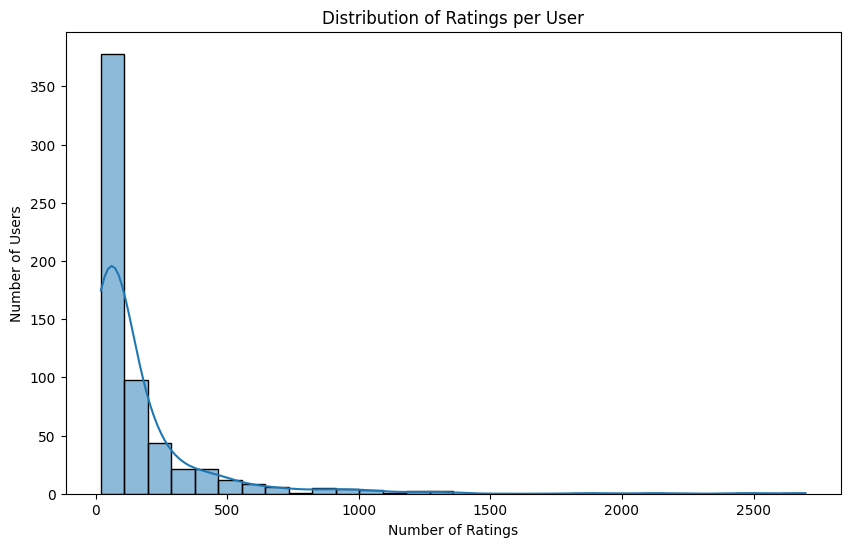

In [ ]:
# Calculate ratings per user
ratings_per_user = full_df.groupby('user_id').size()

# Basic statistics
print("Descriptive Statistics:")
print(ratings_per_user.describe().round(2))

# Histogram of ratings per user
plt.figure(figsize=(10, 6))
sns.histplot(ratings_per_user, bins=30, kde=True)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()

In [ ]:
# Top 10 most active users
top_users = ratings_per_user.sort_values(ascending=False).head(10)
print("Top 10 most active users:\n", top_users)

Top 10 most active users:
 user_id
414.0    2697
599.0    2477
474.0    2108
448.0    1863
274.0    1346
610.0    1302
68.0     1260
380.0    1217
606.0    1115
288.0    1055
dtype: int64


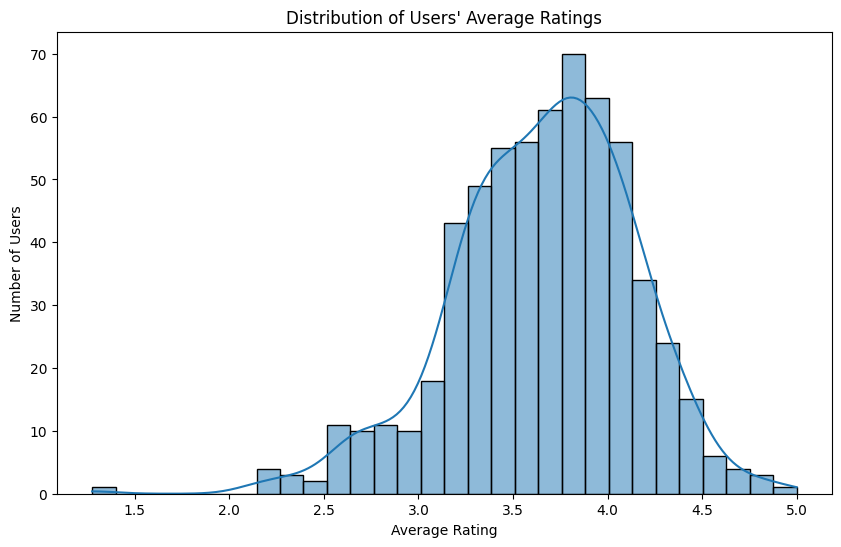

In [ ]:
# Average rating per user
user_avg_rating = full_df.groupby('user_id')['rating'].mean()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(user_avg_rating, bins=30, kde=True)
plt.title('Distribution of Users\' Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Users')
plt.show()

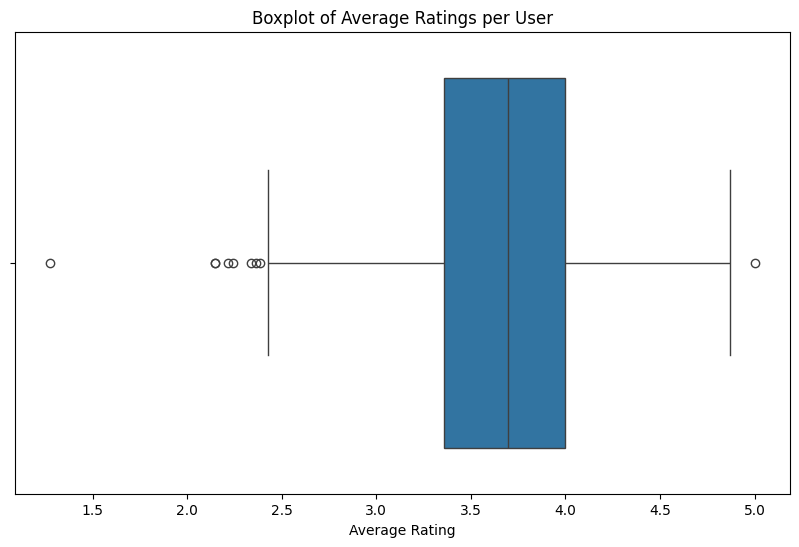

In [ ]:
# Average rating per user
user_avg_rating = full_df.groupby('user_id')['rating'].mean()

# Boxplot of average ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x=user_avg_rating)
plt.title('Boxplot of Average Ratings per User')
plt.xlabel('Average Rating')
plt.show()

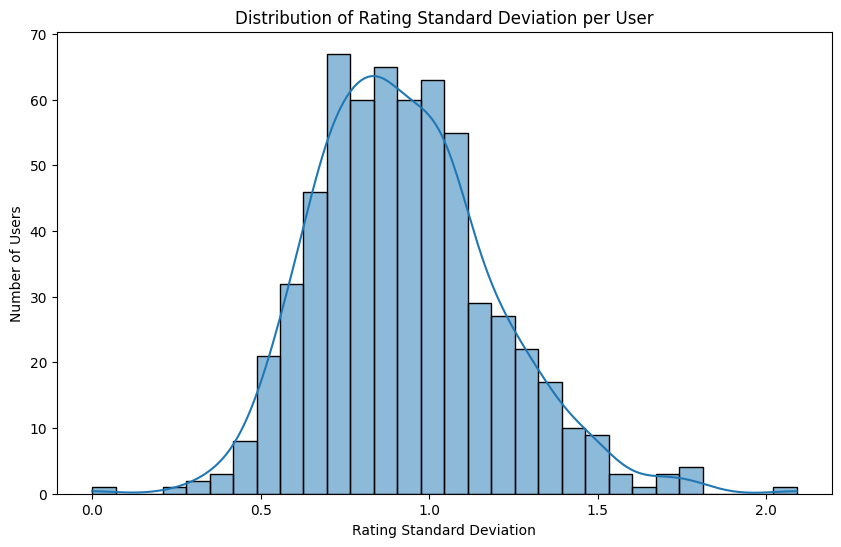

In [ ]:
# Standard deviation of ratings per user
rating_std_per_user = full_df.groupby('user_id')['rating'].std()

# Histogram of rating standard deviation
plt.figure(figsize=(10, 6))
sns.histplot(rating_std_per_user, bins=30, kde=True)
plt.title('Distribution of Rating Standard Deviation per User')
plt.xlabel('Rating Standard Deviation')
plt.ylabel('Number of Users')
plt.show()

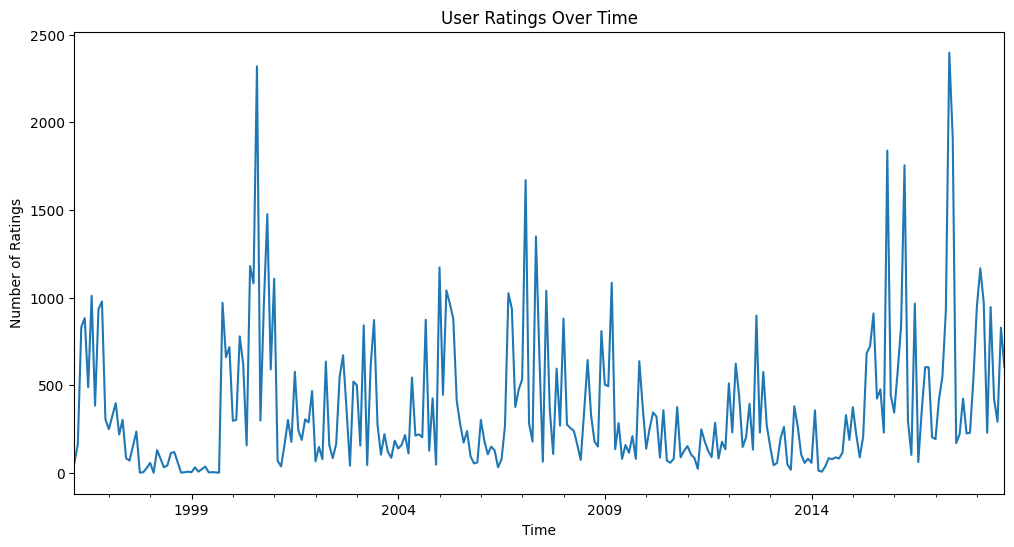

In [ ]:
# Ratings count by month/year
ratings_over_time = full_df.groupby(full_df['timestamp'].dt.to_period('M')).size()

# Time series plot
plt.figure(figsize=(12, 6))
ratings_over_time.plot(kind='line')
plt.title('User Ratings Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.show()

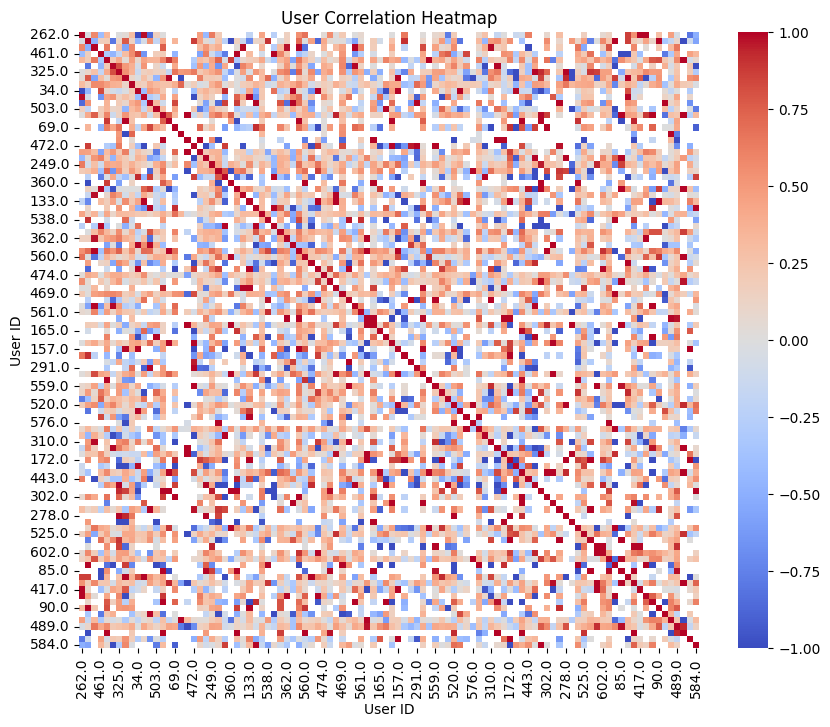

In [ ]:
# Pivot table for user ratings
user_ratings_pivot = full_df.pivot_table(index='user_id', columns='movie_id', values='rating')

# Compute correlation between 100 sampled users
user_corr = user_ratings_pivot.sample(100).T.corr()

# Heatmap of user correlation
plt.figure(figsize=(10, 8))
sns.heatmap(user_corr, cmap='coolwarm')
plt.title('User Correlation Heatmap')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.show()

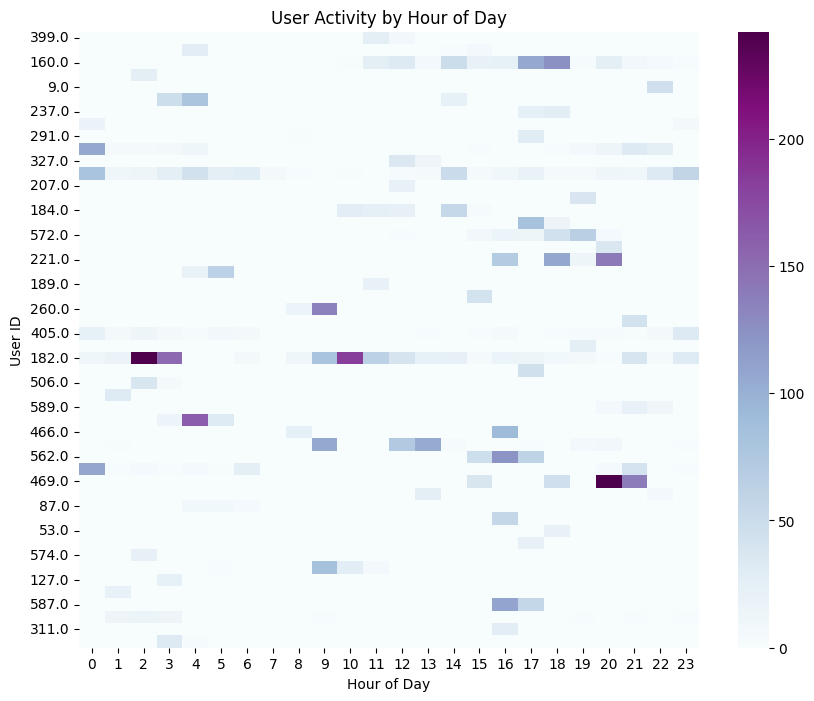

In [ ]:
# Create hour of day column
hourly_df = full_df.copy()
hourly_df['hour_of_day'] = hourly_df['timestamp'].dt.hour

# Activity patterns by hour of day
user_activity_hourly = hourly_df.groupby(['user_id', 'hour_of_day']).size().unstack().fillna(0)

# Heatmap of user activity by hour
plt.figure(figsize=(10, 8))
sns.heatmap(user_activity_hourly.sample(50), cmap="BuPu")
plt.title('User Activity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('User ID')
plt.show()

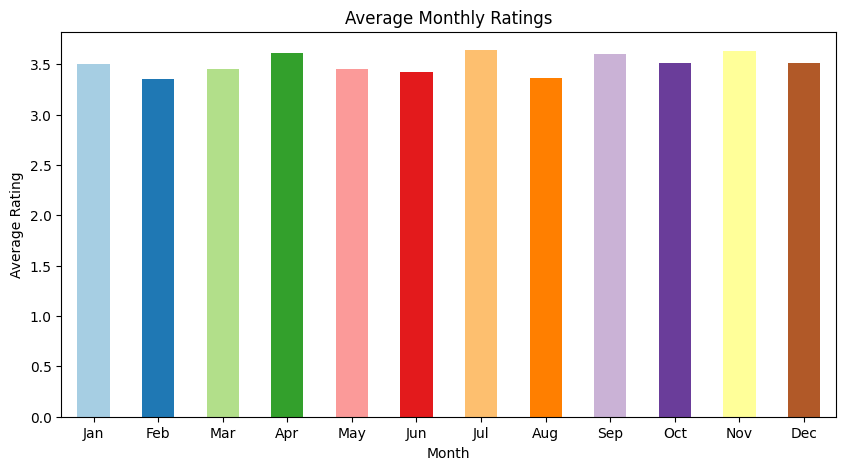

In [ ]:
# Extract month from datetime
monthly_df = full_df.copy()
monthly_df['month'] = monthly_df['timestamp'].dt.month

# Group by month and get average rating
monthly_ratings = monthly_df.groupby('month')['rating'].mean()

# Plot
plt.figure(figsize=(10, 5))
monthly_ratings.plot(kind='bar', color=sns.color_palette('Paired'))
plt.title('Average Monthly Ratings')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.show()

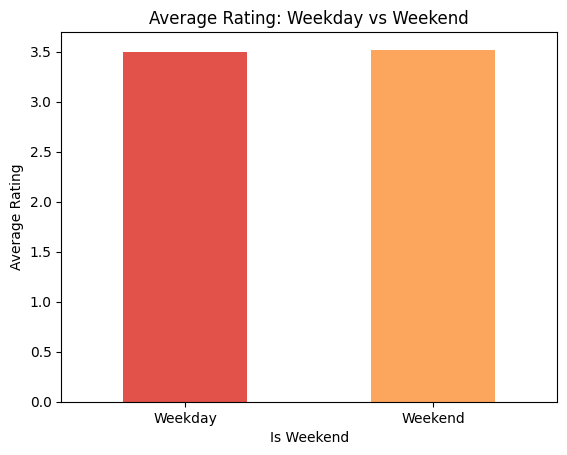

In [ ]:
# Determine if the day is a weekend
weekend_df = full_df.copy()
weekend_df['is_weekend'] = weekend_df['timestamp'].dt.dayofweek >= 5

# Group by is_weekend and calculate average rating
weekend_comparison = weekend_df.groupby('is_weekend')['rating'].mean()

# Plot
weekend_comparison.plot(kind='bar', color=sns.color_palette('Spectral'))
plt.title('Average Rating: Weekday vs Weekend')
plt.xlabel('Is Weekend')
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'], rotation=0)
plt.ylabel('Average Rating')
plt.show()

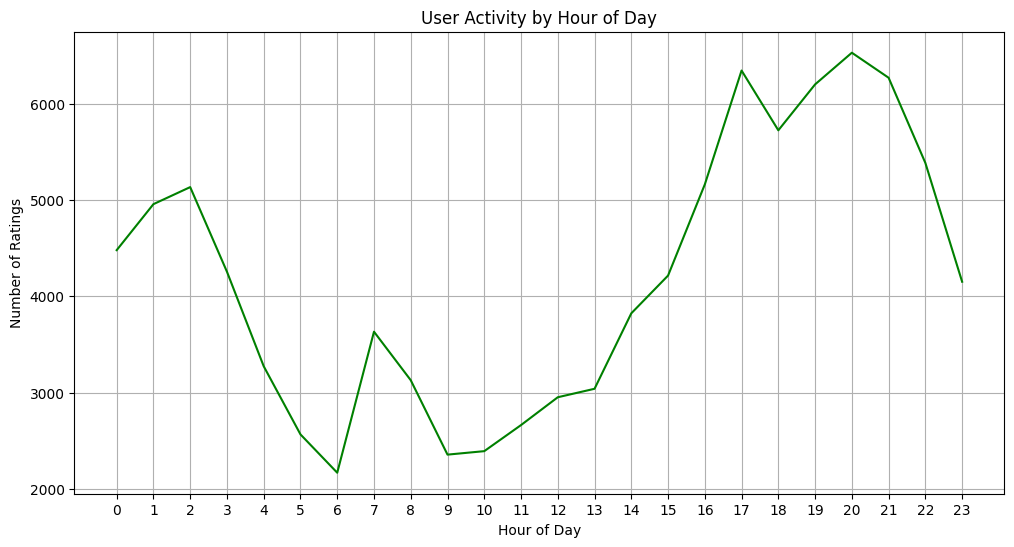

In [ ]:
# Extract hour of day
hourly_df = full_df.copy()
hourly_df['hour_of_day'] = hourly_df['timestamp'].dt.hour

# Group by hour of day and count ratings
hourly_activity = hourly_df.groupby('hour_of_day').size()

# Plot
plt.figure(figsize=(12, 6))
hourly_activity.plot(kind='line', color='g')
plt.title('User Activity by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Ratings')
plt.xticks(range(24))
plt.grid(True)
plt.show()

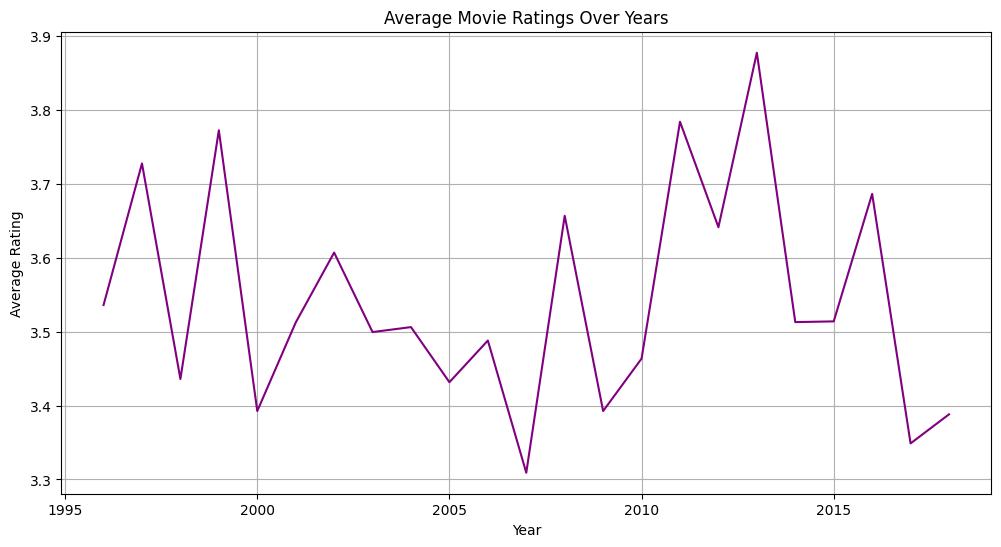

In [ ]:
# Extract year
yearly_df = full_df.copy()
yearly_df['year'] = yearly_df['timestamp'].dt.year

# Group by year and calculate average rating
yearly_ratings = yearly_df.groupby('year')['rating'].mean()

# Plot
plt.figure(figsize=(12, 6))
yearly_ratings.plot(kind='line', color='purple')
plt.title('Average Movie Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

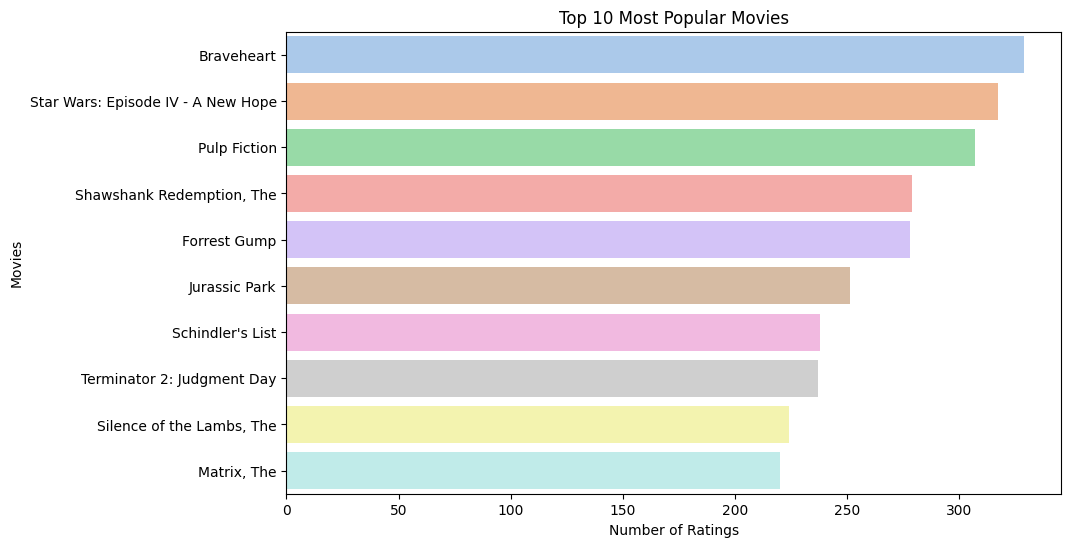

In [ ]:
# Group by movie and count ratings
movie_popularity = full_df.groupby('movie_id').size().sort_values(ascending=False).head(10)

# Fetch movie titles
top_movies = full_df[full_df['movie_id'].isin(movie_popularity.index)]['title'].unique()

# Plot
plt.figure(figsize=(10, 6))
palette = sns.color_palette('pastel')
sns.barplot(x=movie_popularity.values, y=top_movies, hue=top_movies, palette=palette)
plt.title('Top 10 Most Popular Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movies')
plt.show()

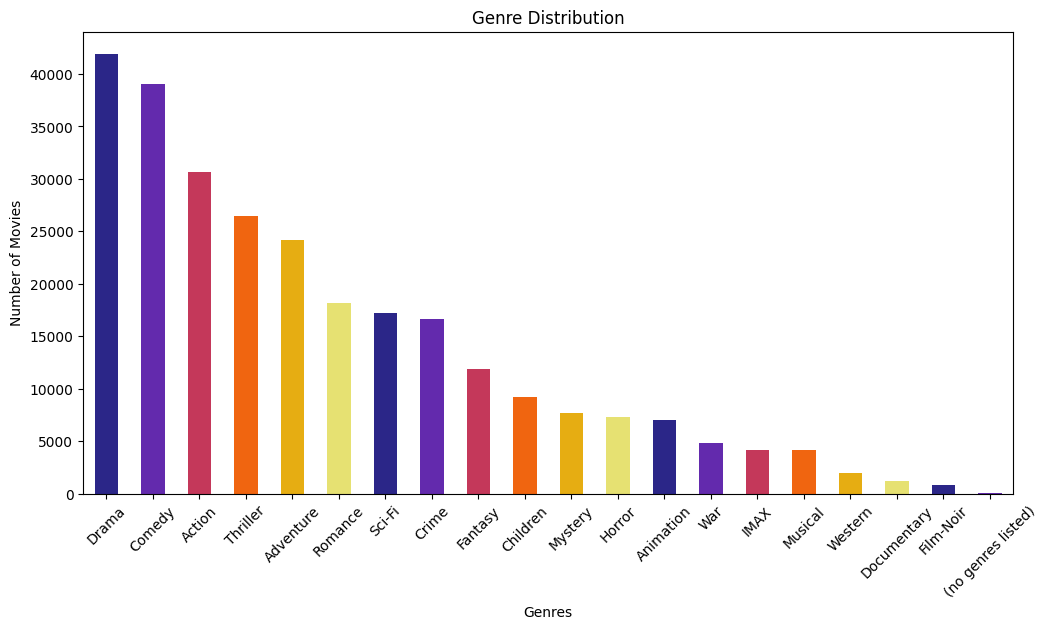

In [ ]:
# Extract genres
all_genres = full_df['genres'].str.split('|').explode()

# Count genres
genre_counts = all_genres.value_counts()

# Plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color=sns.color_palette('CMRmap'))
plt.title('Genre Distribution')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

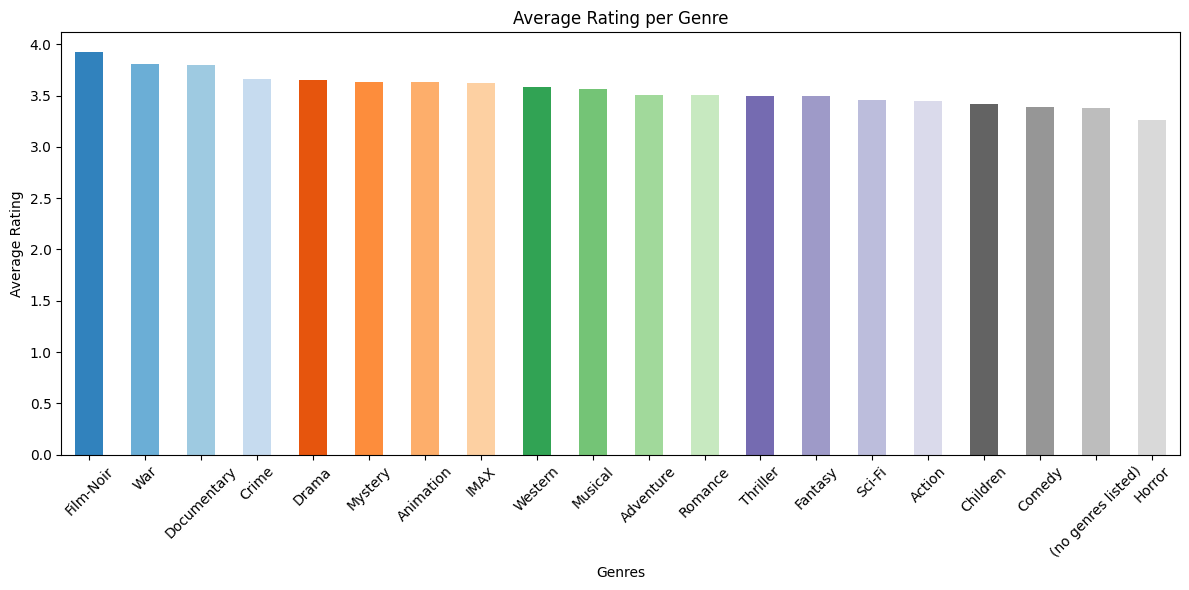

In [ ]:
# Expand the genres into separate rows
expanded_genres = full_df['genres'].str.split('|').explode()

# Create an intermediate DataFrame that includes the expanded genres and ratings
intermediate_df = full_df[['rating']].join(expanded_genres)

# Group by the expanded genres and calculate the average rating for each genre
average_ratings_per_genre = intermediate_df.groupby('genres')['rating'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
average_ratings_per_genre.plot(kind='bar', color=sns.color_palette('tab20c'))
plt.title('Average Rating per Genre')
plt.xlabel('Genres')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

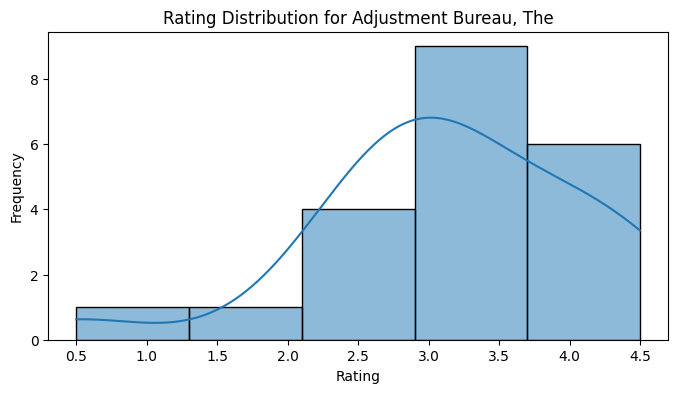

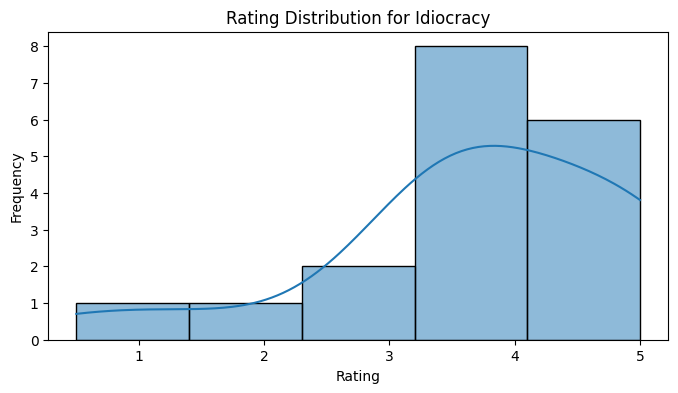

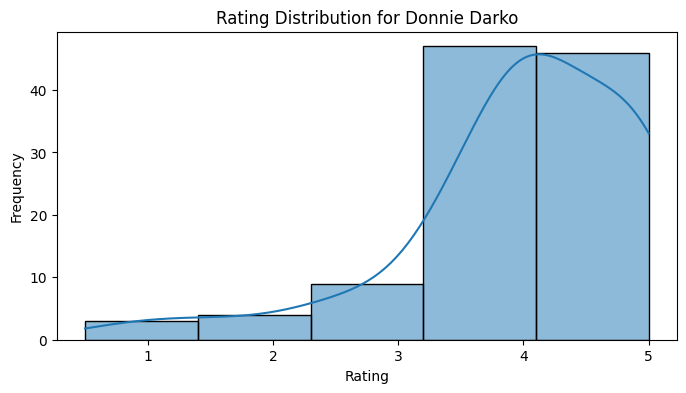

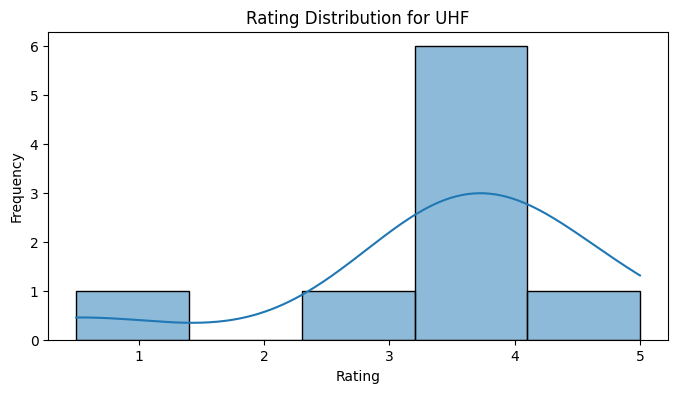

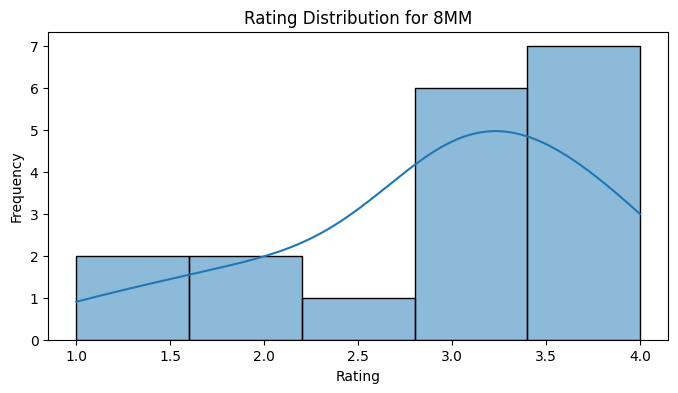

In [ ]:
# Function to plot the rating distribution of individual movies
def plot_rating_distribution(full_df, movie_id):
    # Filter ratings for the selected movie
    movie_ratings = full_df[full_df['movie_id'] == movie_id]['rating']

    # Title of selected movie
    movie_title = full_df[full_df['movie_id'] == movie_id]['title'].iloc[0]

    # Plot
    plt.figure(figsize=(8, 4))
    sns.histplot(movie_ratings, bins=5, kde=True)
    plt.title(f"Rating Distribution for {movie_title}")
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.show()

# Select five random movies
random_movie_ids = full_df['movie_id'].sample(5).values

# Plot rating distribution for these movies
for movie_id in random_movie_ids:
    plot_rating_distribution(full_df, movie_id)

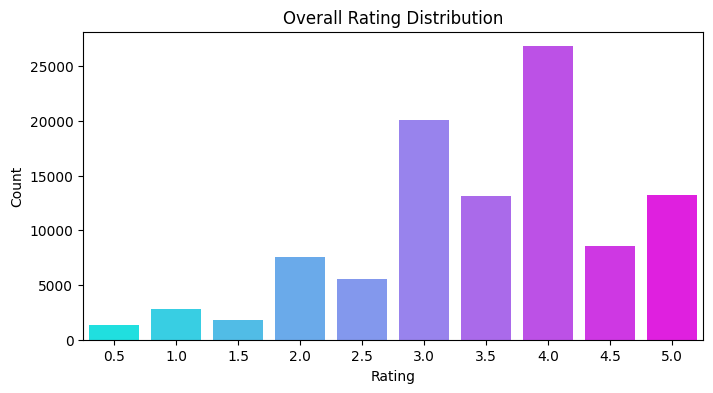

In [ ]:
# Plot the distribution of ratings
plt.figure(figsize=(8, 4))
sns.countplot(x='rating', data=full_df, hue='rating', palette='cool')
plt.title('Overall Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.legend().remove()
plt.show()

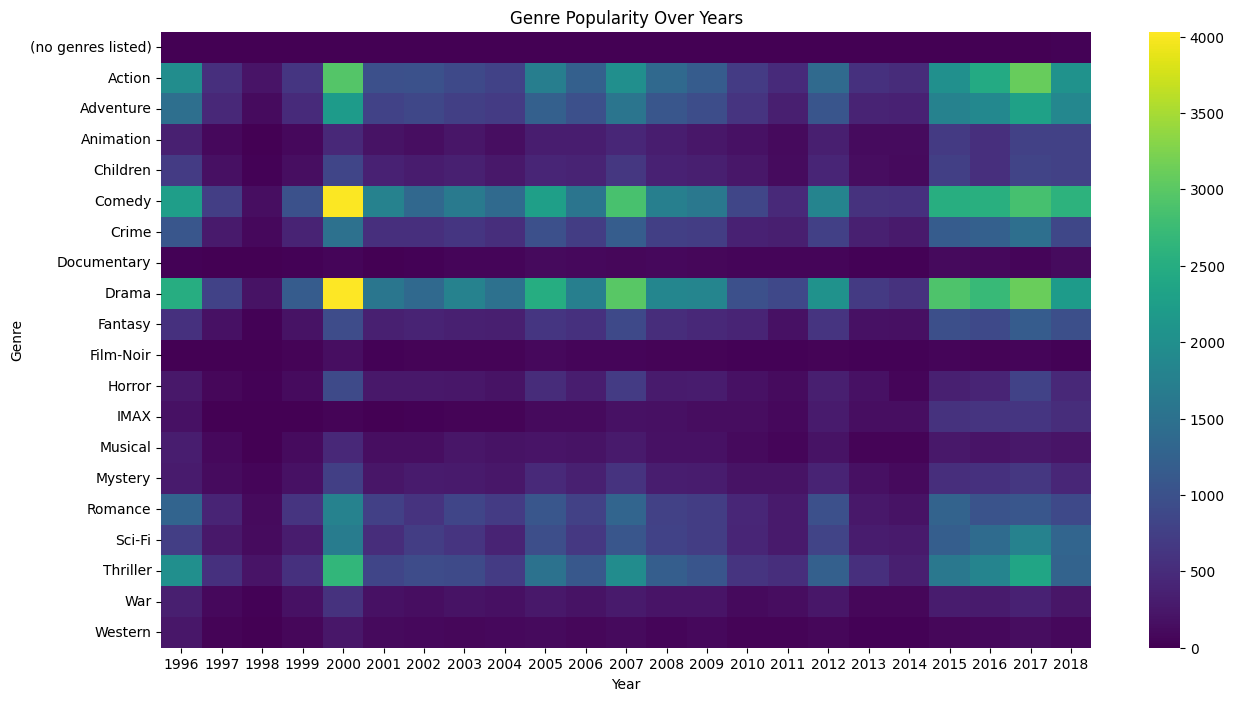

In [ ]:
# Create a copy of the dataframe
yearly_df = full_df.copy()

# Expand the genres into separate rows
expanded_genres = yearly_df['genres'].str.split('|').explode()

# Include the expanded genres and the year in the DataFrame
yearly_df = yearly_df.join(expanded_genres.to_frame('genre'))

# Create a year column
yearly_df['year'] = yearly_df['timestamp'].dt.year

# Group by year and genre and count the occurrences
genre_popularity_per_year = yearly_df.groupby(['year', 'genre']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(15, 8))
sns.heatmap(genre_popularity_per_year.transpose(), cmap='viridis', annot=False)
plt.title('Genre Popularity Over Years')
plt.xlabel('Year')
plt.ylabel('Genre')
plt.show()

# Preprocessing the Data

In [ ]:
# View the DataFrame
full_df.head()

,movie_id,title,genres,user_id,rating,timestamp,release_year,release_decade
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,2000-07-30 18:45:03,1995,1990
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,1996-11-08 06:36:02,1995,1990
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,2005-01-25 06:52:26,1995,1990
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,2017-11-13 12:59:30,1995,1990
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,2011-05-18 05:28:03,1995,1990


In [ ]:
# Data Preprocessor class
class DataPreprocessor:
    def __init__(self, full_df):
        self.full_df = full_df
        self.data = None
        self.unique_user_id = None
        self.unique_movie_id = None
        self.num_users = None
        self.num_movies = None
        self.num_user_features = None
        self.num_movie_features = None

    def preprocess(self):
        # Split genres and convert into indicator variables
        genres = self.full_df['genres'].str.get_dummies('|')

        # Convert release_decade into one-hot encoded features
        release_years = pd.get_dummies(self.full_df['release_decade'], prefix='year')

        # Concatenate genre and release_decade features
        movie_feat = pd.concat([genres, release_years], axis=1)
        movie_feat = torch.from_numpy(movie_feat.values).to(torch.float)

        # Save the number of movie features
        self.num_movie_features = movie_feat.shape[1]

        # Create mappings from unique user indices and movie indices to consecutive values
        unique_user_id = self.full_df['user_id'].unique()
        unique_user_id = pd.DataFrame(data={
            'user_id': unique_user_id,
            'mapped_id': pd.RangeIndex(len(unique_user_id)),
        })

        unique_movie_id = self.full_df['movie_id'].unique()
        unique_movie_id = pd.DataFrame(data={
            'movie_id': unique_movie_id,
            'mapped_id': pd.RangeIndex(len(unique_movie_id)),
        })

        # Save unique user and movie IDs
        self.unique_user_id = unique_user_id
        self.unique_movie_id = unique_movie_id

        # Save the number of users and movies
        self.num_users = len(unique_user_id)
        self.num_movies = len(unique_movie_id)

        # Count the number of ratings per user
        user_rating_counts = self.full_df.groupby('user_id')['rating'].count().reset_index()
        user_rating_counts.columns = ['user_id', 'rating_count']

        # Merge the rating counts with the unique user IDs
        user_feat = pd.merge(unique_user_id, user_rating_counts, on='user_id', how='left')
        user_feat['rating_count'].fillna(0, inplace=True)

        # Create the frequent_rater feature based on a threshold
        frequent_rater_threshold = 25
        user_feat['frequent_rater'] = (user_feat['rating_count'] >= frequent_rater_threshold).astype(int)

        # Convert user features to PyTorch tensor
        user_feat = torch.from_numpy(user_feat[['frequent_rater']].values).to(torch.float)

        # Save the number of user features
        self.num_user_features = user_feat.shape[1]

        # Perform merge to obtain the edges from users to movies
        ratings_user_id = pd.merge(self.full_df['user_id'], unique_user_id,
                                   left_on='user_id', right_on='user_id', how='left')
        ratings_user_id = torch.from_numpy(ratings_user_id['mapped_id'].values)

        ratings_movie_id = pd.merge(self.full_df['movie_id'], unique_movie_id,
                                    left_on='movie_id', right_on='movie_id', how='left')
        ratings_movie_id = torch.from_numpy(ratings_movie_id['mapped_id'].values)

        # Construct the edge_index
        edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)

        # Create a HeteroData object
        data = HeteroData()

        # Save node indices
        data["user"].node_id = torch.arange(len(unique_user_id))
        data["movie"].node_id = torch.arange(len(unique_movie_id))

        # Add the node features and edge indices
        data["user"].x = user_feat
        data["movie"].x = movie_feat
        data["user", "rates", "movie"].edge_index = edge_index_user_to_movie

        # Add reverse edges from movies to users
        data = T.ToUndirected()(data)

        self.data = data

    def split_data(self, num_val=0.1, num_test=0.1, disjoint_train_ratio=0.3, neg_sampling_ratio=2.0):
        assert self.data is not None, "Please call preprocess() before splitting the data."

        # Split the dataset into training, validation, and testing sets
        transform = T.RandomLinkSplit(
            num_val=num_val,
            num_test=num_test,
            disjoint_train_ratio=disjoint_train_ratio,
            neg_sampling_ratio=neg_sampling_ratio,
            add_negative_train_samples=False,
            edge_types=("user", "rates", "movie"),
            rev_edge_types=("movie", "rev_rates", "user"),
        )
        train_data, val_data, test_data = transform(self.data)

        return train_data, val_data, test_data, self.unique_user_id, self.unique_movie_id, self.num_users, self.num_movies, self.num_user_features, self.num_movie_features

In [ ]:
# Preprocess and split the data
preprocessor = DataPreprocessor(full_df)
preprocessor.preprocess()
train_data, val_data, test_data, unique_user_id, unique_movie_id, num_users, num_movies, num_user_features, num_movie_features = preprocessor.split_data()

In [ ]:
# Function to print data characteristics
def summarize_data(data):
    print("Summarizing data:")
    print("================")
    print("Number of user nodes:", data['user'].num_nodes)
    print("Number of movie nodes:", data['movie'].num_nodes)
    print("User node IDs:", data['user'].node_id)
    print("Movie node IDs:", data['movie'].node_id)
    print("User features shape:", data['user'].x.shape)
    print("Movie features shape:", data['movie'].x.shape)
    print("Edge index shape:", data['user', 'rates', 'movie'].edge_index.shape)
    print("Edge labels shape:", data['user', 'rates', 'movie'].edge_label.shape)

# Call the function
summarize_data(train_data)

Summarizing data:
Number of user nodes: 610
Number of movie nodes: 100818
User node IDs: tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 

# Creating DataLoaders

In [ ]:
# Define batch size
BATCH_SIZE = 128

# Create the DataLoaders
edge_label_index_train = train_data["user", "rates", "movie"].edge_label_index
edge_label_train = train_data["user", "rates", "movie"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index_train),
    edge_label=edge_label_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

edge_label_index_val = val_data["user", "rates", "movie"].edge_label_index
edge_label_val = val_data["user", "rates", "movie"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index_val),
    edge_label=edge_label_val,
    batch_size=3 * BATCH_SIZE,
    shuffle=True,
)

edge_label_index_test = test_data["user", "rates", "movie"].edge_label_index
edge_label_test = test_data["user", "rates", "movie"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[20, 10],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "movie"), edge_label_index_test),
    edge_label=edge_label_test,
    batch_size=3 * BATCH_SIZE,
    shuffle=True,
)

In [ ]:
# Directly inspect the first batch from the train_loader
for batch_data in train_loader:
    print(type(batch_data))
    print(batch_data.keys())
    break

<class 'torch_geometric.data.hetero_data.HeteroData'>
['n_id', 'edge_label', 'edge_index', 'num_sampled_nodes', 'edge_label_index', 'input_id', 'e_id', 'x', 'num_sampled_edges', 'node_id']


In [ ]:
# Function to validate dataloaders
def validate_dataloaders(train_loader, val_loader, test_loader):
    for name, loader in [("Train", train_loader), ("Validation", val_loader), ("Test", test_loader)]:
        print(f"Inspecting {name} DataLoader:")

        for batch_id, batch_data in enumerate(loader):
            print(f"  Batch {batch_id+1}:")
            print(f"    Type of batch data: {type(batch_data)}")
            if isinstance(batch_data, HeteroData):
                print(f"    Available Keys: {batch_data.keys()}")

                # Iterate over node types and their features
                for node_type in batch_data.node_types:
                    if 'x' in batch_data[node_type]:
                        node_features = batch_data[node_type]['x']
                        print(f"    Node features for type '{node_type}' shape: {node_features.shape}")
                    else:
                        print(f"    Node features for type '{node_type}' are missing.")

                # Iterate over edge types and their features
                for edge_type in batch_data.edge_types:
                    if 'edge_label' in batch_data[edge_type]:
                        edge_labels = batch_data[edge_type]['edge_label']
                        print(f"    Edge features (edge_label) for type '{edge_type}' shape: {edge_labels.shape}")
                    else:
                        print(f"    Edge features (edge_label) for type '{edge_type}' are missing.")

            print("\n")
            if batch_id >= 2:  # Inspect the first 3 batches
                break

# Call the function
validate_dataloaders(train_loader, val_loader, test_loader)

Inspecting Train DataLoader:
  Batch 1:
    Type of batch data: <class 'torch_geometric.data.hetero_data.HeteroData'>
    Available Keys: ['n_id', 'edge_label', 'edge_index', 'num_sampled_nodes', 'edge_label_index', 'input_id', 'e_id', 'x', 'num_sampled_edges', 'node_id']
    Node features for type 'user' shape: torch.Size([608, 1])
    Node features for type 'movie' shape: torch.Size([2854, 32])
    Edge features (edge_label) for type '('user', 'rates', 'movie')' shape: torch.Size([384])
    Edge features (edge_label) for type '('movie', 'rev_rates', 'user')' are missing.


  Batch 2:
    Type of batch data: <class 'torch_geometric.data.hetero_data.HeteroData'>
    Available Keys: ['n_id', 'edge_label', 'edge_index', 'num_sampled_nodes', 'edge_label_index', 'input_id', 'e_id', 'x', 'num_sampled_edges', 'node_id']
    Node features for type 'user' shape: torch.Size([606, 1])
    Node features for type 'movie' shape: torch.Size([2786, 32])
    Edge features (edge_label) for type '('user

In [ ]:
# Function to check consistency
def check_data_consistency(hetero_data):
    for edge_type in hetero_data.edge_types:
        edge_index = hetero_data[edge_type].edge_index
        num_nodes = max(hetero_data[edge_type].size())
        max_index = edge_index.max().item()
        if max_index >= num_nodes:
            raise ValueError(f'Max edge index {max_index} exceeds number of nodes {num_nodes} for edge type {edge_type}')
        print(f'Edge index for {edge_type} is consistent. Max node index: {max_index}, Number of nodes: {num_nodes}')

# Call the function
batch = next(iter(train_loader))
check_data_consistency(batch)

Edge index for ('user', 'rates', 'movie') is consistent. Max node index: 2370, Number of nodes: 2826
Edge index for ('movie', 'rev_rates', 'user') is consistent. Max node index: 2825, Number of nodes: 2826


# Building the Models

In [ ]:
# BasicGNN class
class BasicGNN(nn.Module):
    def __init__(self, hidden_channels, conv_type='SAGE'):
        super().__init__()
        if conv_type == 'SAGE':
            self.conv1 = SAGEConv(-1, hidden_channels)
            self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        elif conv_type == 'GAT':
            self.conv1 = GATConv((-1, -1), hidden_channels, add_self_loops=False)
            self.conv2 = GATConv((hidden_channels, hidden_channels), hidden_channels, add_self_loops=False)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

In [ ]:
# HeteroGNNModel class
class HeteroGNNModel(nn.Module):
    def __init__(self, hidden_channels, num_users, num_movies, num_user_features, num_movie_features, conv_type='SAGE'):
        super().__init__()
        self.user_lin = nn.Linear(num_user_features, hidden_channels)
        self.user_emb = nn.Embedding(num_users, hidden_channels)
        self.movie_lin = nn.Linear(num_movie_features, hidden_channels)
        self.movie_emb = nn.Embedding(num_movies, hidden_channels)
        self.gnn = BasicGNN(hidden_channels, conv_type=conv_type)
        self.classifier = nn.Linear(hidden_channels, 1)

    def forward(self, data):
        # Transform the features
        user_features_transformed = self.user_lin(data['user'].x)
        movie_features_transformed = self.movie_lin(data['movie'].x)

        # Get embeddings for the nodes in the current batch
        user_embeddings = self.user_emb(data['user'].node_id[:user_features_transformed.size(0)])
        movie_embeddings = self.movie_emb(data['movie'].node_id[:movie_features_transformed.size(0)])

        # Combine transformed features and embeddings
        x_user = user_features_transformed + user_embeddings
        x_movie = movie_features_transformed + movie_embeddings

        # Prepare the input dictionary for the GNN
        x_dict = {
            "user": x_user,
            "movie": x_movie,
        }

        # Convert to heterogeneous GNN
        gnn_hetero = to_hetero(self.gnn, data.metadata(), aggr='sum')
        x_dict = gnn_hetero(x_dict, data.edge_index_dict)

        edge_label_index = data['user', 'rates', 'movie'].edge_label_index
        x_user = x_dict['user'][edge_label_index[0]]
        x_movie = x_dict['movie'][edge_label_index[1]]

        # Compute the dot product between user and movie embeddings
        pred = (x_user * x_movie).sum(dim=-1)

        return pred

In [ ]:
# Model parameters
hidden_channels = 64
num_users = num_users
num_movies = num_movies
num_user_features = num_user_features
num_movie_features = num_movie_features

# Print parameters
print(f"Hidden Channels: {hidden_channels}")
print(f"Number of Users: {num_users}")
print(f"Number of Movies: {num_movies}")
print(f"Number of User Features: {num_user_features}")
print(f"Number of Movie Features: {num_movie_features}")

Hidden Channels: 64
Number of Users: 610
Number of Movies: 9711
Number of User Features: 1
Number of Movie Features: 32


In [ ]:
# Initialize the models
sage_model = HeteroGNNModel(hidden_channels, num_users, num_movies, num_user_features, num_movie_features, conv_type='SAGE')
gat_model = HeteroGNNModel(hidden_channels, num_users, num_movies, num_user_features, num_movie_features, conv_type='GAT')

# Print the models
print(f"SAGE Model:")
print(sage_model)
print()
print(f"GAT Model:")
print(gat_model)

SAGE Model:
HeteroGNNModel(
  (user_lin): Linear(in_features=1, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_lin): Linear(in_features=32, out_features=64, bias=True)
  (movie_emb): Embedding(9711, 64)
  (gnn): BasicGNN(
    (conv1): SAGEConv(-1, 64, aggr=mean)
    (conv2): SAGEConv(64, 64, aggr=mean)
  )
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)

GAT Model:
HeteroGNNModel(
  (user_lin): Linear(in_features=1, out_features=64, bias=True)
  (user_emb): Embedding(610, 64)
  (movie_lin): Linear(in_features=32, out_features=64, bias=True)
  (movie_emb): Embedding(9711, 64)
  (gnn): BasicGNN(
    (conv1): GATConv((-1, -1), 64, heads=1)
    (conv2): GATConv((64, 64), 64, heads=1)
  )
  (classifier): Linear(in_features=64, out_features=1, bias=True)
)


# Training the Models

In [ ]:
# Trainer class
class Trainer:
    def __init__(self, model, optimizer, device, log_dir, scheduler=None, print_every=1):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.device = device
        self.scheduler = scheduler
        self.print_every = print_every
        self.log_dir = log_dir
        self.writer = SummaryWriter(log_dir=self.log_dir)
        self.best_val_loss = float('inf')
        self.logger = self.setup_logger()

    def setup_logger(self):
        logger = logging.getLogger(f"{__name__}.{id(self)}")
        logger.setLevel(logging.INFO)
        logger.propagate = False
        if not logger.handlers:
            console_handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            console_handler.setFormatter(formatter)
            logger.addHandler(console_handler)
        return logger

    def train(self, train_loader, val_loader, num_epochs):
        start_time = time.time()

        for epoch in range(1, num_epochs + 1):
            self.model.train()
            running_loss = 0.0
            correct_predictions = 0
            total_predictions = 0

            for batch in tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch", leave=False):
                batch = batch.to(self.device)
                self.optimizer.zero_grad()

                scores = self.model(batch)
                targets = batch["user", "rates", "movie"].edge_label
                loss = self.loss_fn(scores, targets)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                total_predictions += targets.numel()

                predictions = torch.sigmoid(scores) > 0.5
                correct_predictions += (predictions == targets).sum().item()

            avg_train_loss = running_loss / len(train_loader)
            train_accuracy = correct_predictions / total_predictions

            val_loss, val_accuracy = self.evaluate(val_loader)

            if self.scheduler:
                self.scheduler.step(val_loss)

            self.log_metrics(epoch, avg_train_loss, train_accuracy, val_loss, val_accuracy, start_time)
            self.check_best_model(val_loss)

        self.logger.info(f"Training completed in {time.time() - start_time:.2f} seconds.")

    def evaluate(self, data_loader):
        self.model.eval()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch in data_loader:
                batch = batch.to(self.device)

                scores = self.model(batch)
                targets = batch["user", "rates", "movie"].edge_label
                loss = self.loss_fn(scores, targets)

                running_loss += loss.item()
                total_predictions += targets.numel()

                predictions = torch.sigmoid(scores) > 0.5
                correct_predictions += (predictions == targets).sum().item()

        avg_loss = running_loss / len(data_loader)
        accuracy = correct_predictions / total_predictions

        return avg_loss, accuracy

    def log_metrics(self, epoch, train_loss, train_accuracy, val_loss, val_accuracy, start_time):
        self.writer.add_scalar('Train/Loss', train_loss, epoch)
        self.writer.add_scalar('Train/Accuracy', train_accuracy, epoch)
        self.writer.add_scalar('Val/Loss', val_loss, epoch)
        self.writer.add_scalar('Val/Accuracy', val_accuracy, epoch)

        if epoch % self.print_every == 0:
            elapsed_time = time.time() - start_time
            self.logger.info(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                            f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Elapsed Time: {elapsed_time:.2f}s")

    def check_best_model(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            torch.save(self.model.state_dict(), f"{self.log_dir}/best_model.pth")

    def load_best_model(self):
        best_model_path = f"{self.log_dir}/best_model.pth"
        self.model.load_state_dict(torch.load(best_model_path, map_location=self.device))

In [ ]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the models to the device
sage_model = sage_model.to(device)
gat_model = gat_model.to(device)

In [ ]:
# Define the optimizer
learning_rate = 0.001

optimizer_sage = optim.Adam(sage_model.parameters(), lr=learning_rate)
optimizer_gat = optim.Adam(gat_model.parameters(), lr=learning_rate)

In [ ]:
# Define the learning rate scheduler
scheduler_sage = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sage, mode='min', factor=0.05, patience=2)
scheduler_gat = optim.lr_scheduler.ReduceLROnPlateau(optimizer_gat, mode='min', factor=0.05, patience=2)

In [ ]:
# Create instances of the Trainer for each model
trainer_sage = Trainer(sage_model, optimizer_sage, device, 'logs/sage_model', scheduler_sage)
trainer_gat = Trainer(gat_model, optimizer_gat, device, 'logs/gat_model', scheduler_gat)

In [ ]:
# Train the models
num_epochs = 5

trainer_sage.train(train_loader, val_loader, num_epochs)
print()
trainer_gat.train(train_loader, val_loader, num_epochs)

Epoch 1:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:00:39,684 - __main__.138862026076560 - INFO - Epoch [1/5], Train Loss: 0.7537, Train Accuracy: 0.5028, Val Loss: 0.7548, Val Accuracy: 0.4359, Elapsed Time: 5.84s


Epoch 2:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:00:45,526 - __main__.138862026076560 - INFO - Epoch [2/5], Train Loss: 0.7583, Train Accuracy: 0.4930, Val Loss: 0.7349, Val Accuracy: 0.4449, Elapsed Time: 11.68s


Epoch 3:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:00:51,378 - __main__.138862026076560 - INFO - Epoch [3/5], Train Loss: 0.7441, Train Accuracy: 0.5043, Val Loss: 0.7478, Val Accuracy: 0.4455, Elapsed Time: 17.53s


Epoch 4:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:00:57,281 - __main__.138862026076560 - INFO - Epoch [4/5], Train Loss: 0.7425, Train Accuracy: 0.5025, Val Loss: 0.7513, Val Accuracy: 0.4364, Elapsed Time: 23.44s


Epoch 5:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:01:03,643 - __main__.138862026076560 - INFO - Epoch [5/5], Train Loss: 0.7385, Train Accuracy: 0.5039, Val Loss: 0.7416, Val Accuracy: 0.4395, Elapsed Time: 29.80s
2024-03-19 07:01:03,644 - __main__.138862026076560 - INFO - Training completed in 29.80 seconds.


Epoch 1:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:01:11,075 - __main__.138862026063984 - INFO - Epoch [1/5], Train Loss: 0.7315, Train Accuracy: 0.7941, Val Loss: 0.6809, Val Accuracy: 0.6421, Elapsed Time: 7.43s


Epoch 2:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:01:18,751 - __main__.138862026063984 - INFO - Epoch [2/5], Train Loss: 0.7306, Train Accuracy: 0.7900, Val Loss: 0.7142, Val Accuracy: 0.6490, Elapsed Time: 15.10s


Epoch 3:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:01:26,645 - __main__.138862026063984 - INFO - Epoch [3/5], Train Loss: 0.7222, Train Accuracy: 0.7941, Val Loss: 0.6959, Val Accuracy: 0.6478, Elapsed Time: 23.00s


Epoch 4:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:01:34,249 - __main__.138862026063984 - INFO - Epoch [4/5], Train Loss: 0.7188, Train Accuracy: 0.7961, Val Loss: 0.6992, Val Accuracy: 0.6458, Elapsed Time: 30.60s


Epoch 5:   0%|          | 0/190 [00:00<?, ?batch/s]

2024-03-19 07:01:41,947 - __main__.138862026063984 - INFO - Epoch [5/5], Train Loss: 0.7163, Train Accuracy: 0.8004, Val Loss: 0.7072, Val Accuracy: 0.6479, Elapsed Time: 38.30s
2024-03-19 07:01:41,948 - __main__.138862026063984 - INFO - Training completed in 38.30 seconds.


# Plotting the Training

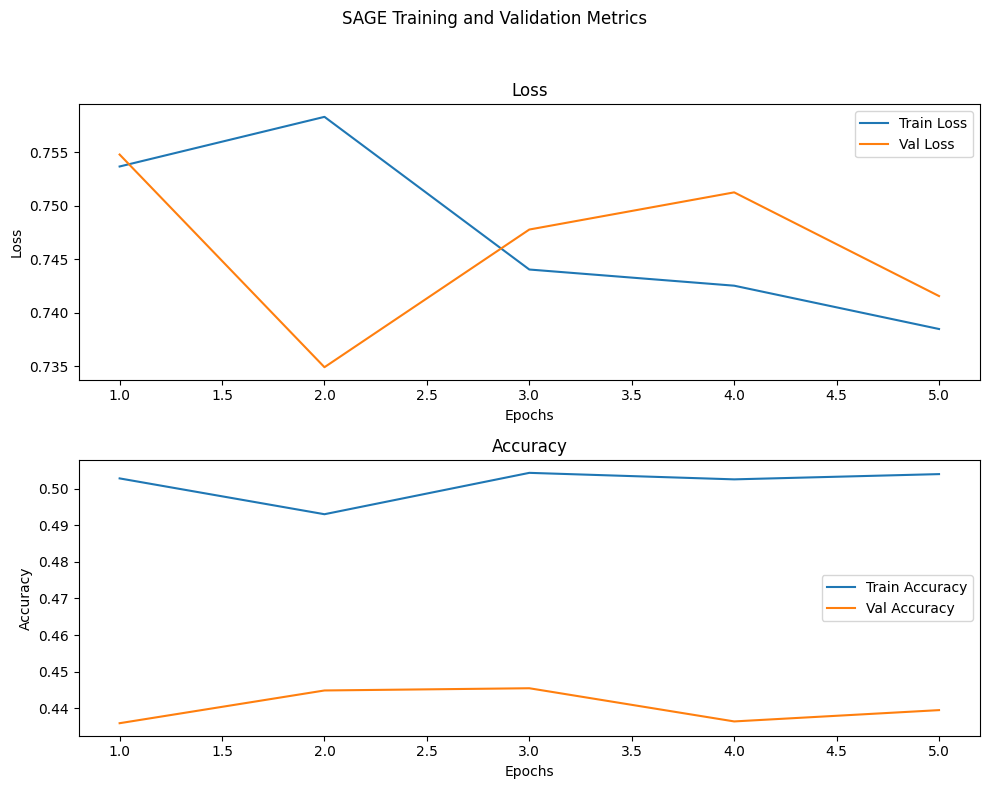

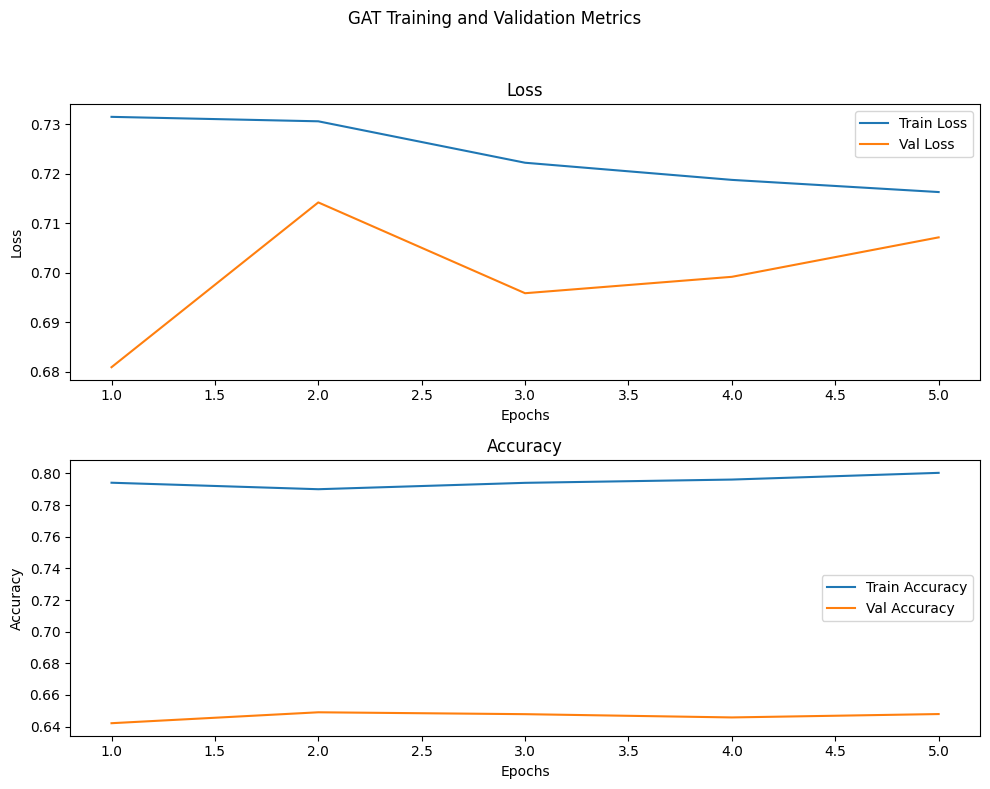

In [ ]:
# Function to plot training metrics
def plot_metrics(log_dir, model_name):
    # Load the TensorBoard event files
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    # Extract the scalar metrics logged during training
    scalars = event_acc.Tags()['scalars']

    # Set up the plot
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    fig.suptitle(f'{model_name} Training and Validation Metrics')

    # Plot training and validation loss
    try:
        train_loss = event_acc.Scalars('Train/Loss')
        val_loss = event_acc.Scalars('Val/Loss')
        axes[0].plot([e.step for e in train_loss], [e.value for e in train_loss], label='Train Loss')
        axes[0].plot([e.step for e in val_loss], [e.value for e in val_loss], label='Val Loss')
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[0].set_title('Loss')
    except KeyError:
        print(f"Warning: Loss values not found for {model_name}")

    # Plot training and validation accuracy
    try:
        train_accuracy = event_acc.Scalars('Train/Accuracy')
        val_accuracy = event_acc.Scalars('Val/Accuracy')
        axes[1].plot([e.step for e in train_accuracy], [e.value for e in train_accuracy], label='Train Accuracy')
        axes[1].plot([e.step for e in val_accuracy], [e.value for e in val_accuracy], label='Val Accuracy')
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].set_title('Accuracy')
    except KeyError:
        print(f"Warning: Accuracy values not found for {model_name}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Call the function
plot_metrics("logs/sage_model", "SAGE")
plot_metrics("logs/gat_model", "GAT")

# Evaluating the Models

In [ ]:
# Load the best models
trainer_sage.load_best_model()
trainer_gat.load_best_model()

# Move the models to the device
best_sage_model = trainer_sage.model.to(device)
best_gat_model = trainer_gat.model.to(device)

# Evaluate the models on the test set
test_loss_sage, test_acc_sage = trainer_sage.evaluate(test_loader)
test_loss_gat, test_acc_gat = trainer_gat.evaluate(test_loader)

# Print the test results
print("SAGE Model - Test Loss: {:.4f}, Test Accuracy: {}".format(test_loss_sage, test_acc_sage))
print("GAT Model - Test Loss: {:.4f}, Test Accuracy: {}".format(test_loss_gat, test_acc_gat))

SAGE Model - Test Loss: 0.7451, Test Accuracy: 0.42852891578216445
GAT Model - Test Loss: 0.7198, Test Accuracy: 0.6466510156620264
